In [1]:
#Imports
import tensorflow as tf
import csv
from collections import OrderedDict
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import os
from sklearn.preprocessing import StandardScaler
from skimage.util import numpy_pad
from skimage import transform
from sklearn.model_selection import train_test_split
import time
import pickle
import sys
import six
%matplotlib inline


In [3]:
#for python 2 and 3 compatibility
import future        # pip install future
#import six           # pip install six
from __future__ import print_function

In [5]:
#verify python version and tensorflow version
print(sys.version_info)
print(tf.__version__)

sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)
1.0.0


All four files are binary and include a 512 byte header followed by the file's data. 
The header mostly contains technical scan parameters and is largely identical across all images. 
With the exception of the field 'data_scale_factor', we do not expect information from the header to be necessary or useful for the competition task. 

```
File starts with 512 bytes (256 unint16) header, then the rest is unint16.
Data file order: AYX (angle, vertical axis, horizontal axis)
Axis Name, Stride, Number of samples, Axis Length
XAxis, 1, Nx=512, Lx=1.0 meters
YAxis, 512, Ny=660, Ly=2.0955 meters
Angular, 337920, Na=16, La=360-degrees
The data type of this file is 16bit unsigned integer.
```

## get image data

In [7]:
img_paths = glob.glob('./aps/*.aps')
def read_header(infile):
    """Read image header (first 512 bytes)
    """
    h = dict()
    try:
        fid = open(infile, 'r+b')
    except IOError:
        return None
        
    h['filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
    h['parent_filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
    h['comments1'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
    h['comments2'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
    h['energy_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['config_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['file_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['trans_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scan_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['data_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['date_modified'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 16))
    h['frequency'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['mat_velocity'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['num_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_polarization_channels'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['spare00'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['adc_min_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['adc_max_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['band_width'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['spare01'] = np.fromfile(fid, dtype = np.int16, count = 5)
    h['polarization_type'] = np.fromfile(fid, dtype = np.int16, count = 4)
    h['record_header_size'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['word_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['word_precision'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['min_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['max_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['avg_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['data_scale_factor'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['data_units'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['surf_removal'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['edge_weighting'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['x_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['y_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['z_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['t_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
    h['spare02'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['x_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['scan_orientation'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scan_direction'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['data_storage_order'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scanner_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['x_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['t_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['num_x_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_y_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_z_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['num_t_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
    h['x_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['date_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
    h['time_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
    h['depth_recon'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['elevation_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['roll_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['azimuth_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['adc_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['spare06'] = np.fromfile(fid, dtype = np.int16, count = 1)
    h['scanner_radius'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['x_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['y_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['z_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['t_delay'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['range_gate_start'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['range_gate_end'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['ahis_software_version'] = np.fromfile(fid, dtype = np.float32, count = 1)
    h['spare_end'] = np.fromfile(fid, dtype = np.float32, count = 10)
    return h

In [21]:
def read_data(infile):
    """Read any of the 4 types of image files, returns a numpy array of the image contents
    """
    extension = os.path.splitext(infile)[1]

    h = read_header(infile)
    if h == None:
        return None
    nx = int(h['num_x_pts'])
    ny = int(h['num_y_pts'])
    nt = int(h['num_t_pts'])
    fid = open(infile, 'rb')
    #if file doesn't exist, return None
    try:
        fid = open(infile, 'r+b')
    except IOError:
        return None
    
    fid.seek(512) #skip header
    if extension == '.aps' or extension == '.a3daps':
        if(h['word_type']==7): #float32
            data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
        elif(h['word_type']==4): #uint16
            data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)
        data = data * h['data_scale_factor'] #scaling factor
        """
        nx, ny, nt, order F gives us 512 (width) x 660 (height) x 16 (angle)
        then rotate that 90 degrees to make it 660 x 512 x 16
        
        #data = data.reshape(nx, ny, nt, order='F').copy() #make N-d image
        #data = np.rot90(data,k=1)
        
        Other option, to get angle as the first dimension:
        nt, ny, nx order C gives 16 x 660 x 512; it's upside down, so flip it
        #data = data.reshape(nt, ny, nx, order='C').copy() #make N-d image
        #data = np.flip(data,axis=1)
        """
        data = data.reshape(nt, ny, nx, order='C').copy() #make N-d image
        data = np.flip(data,axis=1)
        
    elif extension == '.a3d':
        if(h['word_type']==7): #float32
            data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
        elif(h['word_type']==4): #uint16
            data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)
        data = data * h['data_scale_factor'] #scaling factor
        data = data.reshape(nx, nt, ny, order='F').copy() #make N-d image
    elif extension == '.ahi':
        data = np.fromfile(fid, dtype = np.float32, count = 2* nx * ny * nt)
        data = data.reshape(2, ny, nx, nt, order='F').copy()
        real = data[0,:,:,:].copy()
        imag = data[1,:,:,:].copy()
    fid.close()
    if extension != '.ahi':
        return data
    else:
        return real, imag

### pad image to make it square, then resize to match the required size of pre-trained network

In [8]:
def resize(img, height=224, width=224):
    """
    img: original angle 16, height 660, width 512
    height: desired height
    width: desired width
    
    First pads the shorter side with zeros, then resizes the square image.
    Since we pad with zeros, resize should be done before rescaling to between -0.5 and 0.5
    return: square resized image (16 angles by 224 height by 224 width)
    """
    angle, height0, width0 = img.shape
    pad_angle = (0,0)
    
    if height0 == width0:
        return img
    elif height0 > width0:
        pad_height = (0,0)
        diff = height0-width0
        pad_left = diff // 2
        pad_right = diff - pad_left
        pad_width = (pad_left,pad_right)
        pad = (pad_angle, pad_height, pad_width)
    else:
        pad_width = (0,0)
        diff = width0 - height0
        pad_up = diff // 2
        pad_down = diff - pad_up
        pad_height = (pad_up,pad_down)
        pad = (pad_angle, pad_height, pad_width)
        
    constant_values = ((0,0),(0,0),(0,0))
    img_square = numpy_pad(img, pad_width=pad, mode='constant', constant_values=constant_values)
    img_resized = transform.resize(img_square, (angle, 224, 224), mode='constant')
    
    #also duplicate to convert from single channel to rgb channel
        
    return img_resized

In [9]:
def rescale(img,out_left=0,out_right=1.0):
    '''
    img: angle x height x width
    returns: image with min value set out_left and max to out_right
    
    Since we're feeding this into vgg, it expects values between 0 and 1,
    and multiplies by 255.
    '''
    in_left = float(np.min(img))
    in_right = float(np.max(img))
    out_left = float(out_left)
    out_right = float(out_right)
    new_img = (img - in_left) * (out_right - out_left) / (in_right - in_left) + out_left
    return new_img

## select desired angles

In [11]:
def pick_angles(img, angles_bool=[True, False, False, True, True, True, False, False, True, False, False, True, True, True, False, False]):
    """
    img: original image with 16 angles
    angles: 
        0: front
        3: front left
        4: left
        5: back left
        8: back
        11: back right
        12: right
        13: front right
    """
    return img[angles_bool,:,:]

def get_angles_bool(num_angles=16, angles = [0,3,4,5,8,11,12,13]):
    """
    Calculate the boolean list once.
    Then pass the angles_bool to pick_angles, to select the desired 
    angles from each image.
    """
    angles_bool = [False] * num_angles
    for ii in angles:
        angles_bool[ii] = True
        
    return angles_bool

### get path to image file and the value of its labels

In [48]:
def get_xy(labels_file='./stage1_labels.csv', n_zones=17, pre_path='./aps/', file_ext='.aps'):
    """
    One row for each unique file name; we'll see each file name
    multiple times (17 times), so I may want to use a dictionary

    I'll have 17 columns, one for each region. It will either contain
    0 or 1.

    Note that it's not really one-hot encoding; I'll be predicting probabilities,
    and each region should be independent of each other, so I have to be careful
    about the activation function.  Softmax makes all outputs sum to 1.
    If I use a linear activation, then it's more like logistic regression; it
    should output a number between 0 and 1
    
    returns:
    image_paths: list of paths to the image files
    target_zone_arr: 2D np array of labels, each row is for one 
    """
    labels_d = OrderedDict()
    with open(labels_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        header = next(reader)
        for row in reader:
            name_zone = row[0]

            img_name, zone = name_zone.split('_')
            if img_name in labels_d:
                zone_prob = labels_d[img_name]
            else:
                zone_prob = np.zeros(n_zones)
                labels_d[img_name] = zone_prob
            """
            zone looks like 'Zone13'; split it and convert number to int
            """
            zone_int = int(zone.split('Zone')[1])
            prob_int = int(row[1])
            zone_prob[zone_int-1] = prob_int

    """
    put the image file names into an ordered list
    combine the zone and probabilities into an np array
    """
    image_paths = []

    #create a dummy row so that I can concatenate all rows
    target_zone_arr = np.zeros((1,n_zones))
    for img_name, target_zone in labels_d.items():
        image_paths.append(pre_path + img_name + file_ext)
        target_zone_arr = np.concatenate( [target_zone_arr,np.reshape(target_zone,(1,-1))], axis=0)
    #remove the first dummy row
    target_zone_arr = target_zone_arr[1:,:]
    
    return image_paths, target_zone_arr, labels_d

In [49]:
image_paths, target_zone_arr, labels_d = get_xy(labels_file='./stage1_labels.csv', n_zones=17, pre_path='./aps/', file_ext='.aps')

## shuffle and split

In [53]:
image_paths_train, image_paths_test, y_train, y_test, i_train, i_test = train_test_split(image_paths, target_zone_arr, range(len(image_paths)), test_size=0.20, random_state=0)

In [64]:
VGG_HEIGHT = 224
VGG_WIDTH = 224

def yield_batch(img_paths, y, batch_size=10):
    """
    Given the list of files (already split into training set, and randomized)
    read in a batch of images and yield.
    """
    num_records = len(y)
    img_l = []
    y_l = []
    b_ii = 1
    
    for ii in range(0, num_records):
        img = read_data(img_paths[ii])
        if img is None:
            continue
        #reshape to fit the size for pretrained model
        img = resize(img,height=VGG_HEIGHT,width=VGG_WIDTH)
        img = rescale(img)
        img_l.append(img)
        y_l.append(y[ii])
        
        '''
        If we have a full batch, then yield batch
        Or if we've seen all data points, yield what we have as the last batch
        Also reset the image and y lists
        '''
        if (b_ii % batch_size == 0):
            x_batch = np.array(img_l)
            y_batch = np.array(y_l)
            img_l = []
            y_l = []
            yield x_batch, y_batch
        b_ii +=1 #count actual available images in batch
        
    #yield once more for anything left over that isn't a full batch
    if len(img_l) > 0:
        x_batch = np.array(img_l)
        y_batch = np.array(y_l)
        yield x_batch,y_batch

In [ ]:
"""
How to use the yield function:
use a for loop (it's an iterator)
"""
batch_i = 0
for x_batch, y_batch in yield_batch(image_paths_test, y_test, batch_size=10):
    print(batch_i)
    print(x_batch.shape)
    print(y_batch.shape)
    batch_i +=1

## Explore images

In [69]:
x_batch, y_batch = next(yield_batch(image_paths_train, y_train, batch_size=10))

In [70]:
x_batch.shape

(8, 16, 224, 224)

In [72]:
y_batch.shape

(8, 17)

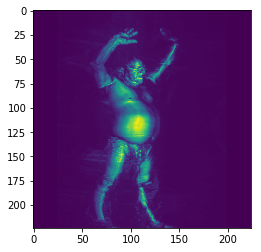

In [74]:
plt.imshow(x_batch[0][14]);

## Use VGG for transfer learning
Clone the VGG repository:
```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

Need to install urllib3 package to use urllib

python 2 uses urllib
python 3 splits urllib into urllib.request and urllib.error

Also install tqdm

In [84]:
"""
Download pre-trained weights and biases, found in vgg16.npy
"""
#from urllib.request import urlretrieve #for python 3
from urllib import urlretrieve #for python 2
from os.path import isfile, isdir
from tqdm import tqdm


vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Exception: VGG directory doesn't exist!